### TRMM PNG monitoring

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
from mpl_toolkits.basemap import maskoceans, interp

In [79]:
import numpy as np
import pandas as pd
import xarray as xray
from netCDF4 import MFDataset
from datetime import datetime, timedelta
from glob import glob
import palettable
import folium
from folium.map import FeatureGroup

In [3]:
import io
import base64

In [4]:
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [5]:
dpath = '/Users/nicolasf/data/TRMM/daily/'
climpath = '/Users/nicolasf/data/TRMM/climatology/daily/2001_2015/'

In [6]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xray.open_dataset(path) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

    #paths = sorted(glob(files))
    datasets = [process_one_path(p) for p in files]
    combined = xray.concat(datasets, dim)
    return combined

### set up the domain 

In [7]:
domain = {'latmin':-13, 'lonmin':155., 'latmax':-5, 'lonmax':168.}

### original resolution of the dataset

In [8]:
res = 0.25 

### factor by which the resolution will be increased

In [9]:
interp_factor = 30

### set up the map

In [10]:
m = bm(projection='cyl', llcrnrlon=domain['lonmin']+0.25, \
              llcrnrlat=domain['latmin']+0.25, \
              urcrnrlon=domain['lonmax']-0.25, \
              urcrnrlat=domain['latmax']-0.25, resolution='f')

In [ ]:
# m = bm(projection='cyl', llcrnrlon=domain['lonmin'], \
#               llcrnrlat=domain['latmin'], \
#               urcrnrlon=domain['lonmax'], \
#               urcrnrlat=domain['latmax'], resolution='f')

In [11]:
today = datetime.utcnow()

In [12]:
today

datetime.datetime(2016, 8, 1, 3, 47, 30, 984635)

### lag is the lag in days

In [13]:
lag = 4

### ndays is the number of days to retrieve (i.e. last 30 days, last 60 days, etc)

In [14]:
ndays = 90

### get the current TRMM date

In [15]:
trmm_date = today - timedelta(days=lag)

In [16]:
trmm_date

datetime.datetime(2016, 7, 28, 3, 47, 30, 984635)

### creates the list of days 

In [17]:
realtime = pd.date_range(start=trmm_date - timedelta(days=ndays-1), end=trmm_date)

In [18]:
realtime

DatetimeIndex(['2016-04-30 03:47:30.984635', '2016-05-01 03:47:30.984635',
               '2016-05-02 03:47:30.984635', '2016-05-03 03:47:30.984635',
               '2016-05-04 03:47:30.984635', '2016-05-05 03:47:30.984635',
               '2016-05-06 03:47:30.984635', '2016-05-07 03:47:30.984635',
               '2016-05-08 03:47:30.984635', '2016-05-09 03:47:30.984635',
               '2016-05-10 03:47:30.984635', '2016-05-11 03:47:30.984635',
               '2016-05-12 03:47:30.984635', '2016-05-13 03:47:30.984635',
               '2016-05-14 03:47:30.984635', '2016-05-15 03:47:30.984635',
               '2016-05-16 03:47:30.984635', '2016-05-17 03:47:30.984635',
               '2016-05-18 03:47:30.984635', '2016-05-19 03:47:30.984635',
               '2016-05-20 03:47:30.984635', '2016-05-21 03:47:30.984635',
               '2016-05-22 03:47:30.984635', '2016-05-23 03:47:30.984635',
               '2016-05-24 03:47:30.984635', '2016-05-25 03:47:30.984635',
               '2016-05-2

In [19]:
print("calculating realtime data for {:%Y-%m-%d} to {:%Y-%m-%d}".format(realtime[0], realtime[-1]))

calculating realtime data for 2016-04-30 to 2016-07-28


In [20]:
lfiles = []
for d in realtime: 
    fname  = dpath + "3B42RT_daily.{}.nc".format(d.strftime("%Y.%m.%d"))
    lfiles.append(fname)

### reads the files

In [21]:
dset_realtime = read_netcdfs(lfiles, 'time')

### selects the domain

In [22]:
dset_realtime = dset_realtime.sel(lat=slice(domain['latmin'], domain['latmax']), \
                                  lon=slice(domain['lonmin'], domain['lonmax']))

### reads the climatology

In [23]:
clim_files = []
for d in realtime: 
    fname  = climpath + "3B42_daily.{}.nc".format(d.strftime("%m.%d"))
    clim_files.append(fname)

In [24]:
dset_clim = read_netcdfs(clim_files, 'time')

### selects the domain

In [25]:
dset_clim = dset_clim.sel(lat=slice(domain['latmin'], domain['latmax']), \
                          lon=slice(domain['lonmin'], domain['lonmax']))

### calculates the averages and cumulative rainfall

In [26]:
clim_ave = dset_clim.mean('time')
clim_sum = dset_clim.sum('time')

In [27]:
realtime_ave = dset_realtime.mean('time')
realtime_sum = dset_realtime.sum('time')

In [28]:
realtime_ave

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 52)
Coordinates:
  * lon      (lon) float32 155.125 155.375 155.625 155.875 156.125 156.375 ...
  * lat      (lat) float32 -12.875 -12.625 -12.375 -12.125 -11.875 -11.625 ...
Data variables:
    trmm     (lat, lon) float64 2.197 2.093 2.022 1.818 1.878 2.143 2.288 ...

In [29]:
realtime_ave['clim'] = (['lat','lon'], clim_ave['trmm'].data)
realtime_sum['clim'] = (['lat','lon'], clim_sum['trmm'].data)

### calculates the anomalies

In [30]:
raw = realtime_sum['trmm']

In [31]:
anoms = realtime_sum['trmm'] - realtime_sum['clim']

In [32]:
anomsp = ((realtime_sum['trmm'] - realtime_sum['clim']) / realtime_sum['clim']) * 100.

In [33]:
pp = realtime_sum['trmm'] / realtime_sum['clim'] * 100.

### gets the cmap

In [34]:
cmap_anoms = palettable.colorbrewer.diverging.BrBG_11.mpl_colormap

### set up the dictionnary with the cities and their coordinates 

The coordinates can be viewed on geohack, follow the links on the right of the wikipedia page for the 
corresponding city

In [35]:
# cities = {}
# cities['Port Moresby'] = (-9.513639, 147.218806)
# cities['Lae'] = (-6.73333, 147)
# cities['Alotau'] = (-10.316667, 150.433333)
# cities['Daru'] = (-9.083333, 143.2)
# cities['Madang'] = (-5.216667, 145.8)
# cities['Wewak'] = (-3.55, 143.633333)

In [36]:
def round_10(x, how='down'):
    import math
    if how == 'up': 
        return int(math.ceil(x / 10.0)) * 10
    elif how == 'down': 
        return int(math.floor(x / 10.0)) * 10

In [37]:
def plot_cities(ax, cities): 
    for k in cities: 
        ax.plot(cities[k][1],cities[k][0], 'ro', transform=ax.transData)
        ax.text(cities[k][1]+0.1,cities[k][0]+0.01, k, transform=ax.transData, \
                fontsize=14, color='#0B0B61')

In [38]:
def get_limits(Dataarray, robust=True, robust_percentile=2, center=None): 
        # ravel and removes nans for calculation of intervals etc
        calc_data = Dataarray.data
        calc_data = np.ravel(calc_data[np.isfinite(calc_data)])

        # the following is borrowed from xray
        # see: plot.py in xray/xray/plot
        vmin = np.percentile(calc_data, robust_percentile) if robust else calc_data.min()
        vmax = np.percentile(calc_data, 100 - robust_percentile) if robust else calc_data.max()

        del(calc_data)

        # Simple heuristics for whether these data should  have a divergent map
        divergent = ((vmin < 0) and (vmax > 0)) or center is not None

        # Now set center to 0 so math below makes sense
        if center is None:
            center = 0

        # A divergent map should be symmetric around the center value
        if divergent:
            vlim = max(abs(vmin - center), abs(vmax - center))
            vmin, vmax = -vlim, vlim

        # Now add in the centering value and set the limits
        vmin += center
        vmax += center
        
        vmin = round_10(vmin)
        if center == 0: 
            vmax = round_10(vmax, how='up')
        else: 
            vmax = round_10(vmax)
            
        
        step = round_10((vmax - vmin) / 12)

        return (vmin, vmax, step)

In [39]:
def plot_map(m, Dataarray, vmin=None, vmax=None, step=None, title="", units="", draw_cities=True, \
             cmap=plt.get_cmap('Blues'), mask_oceans=True, extend='max'): 
    
    lon = Dataarray.lon
    lat = Dataarray.lat
    
    nlats = interp_factor * len(lat)
    nlons = interp_factor * len(lon)
    
    lons = np.linspace(float(min(lon)),float(max(lon)),nlons)
    lats = np.linspace(float(min(lat)),float(max(lat)),nlats)
    
    lons, lats = np.meshgrid(lons, lats)
    
    offset = np.diff(lons)[0][0] / 2.
#     offset=0

    x, y = m(lons-offset, lats-offset)
    
    if vmin is None or vmax is None or step is None: 
        vmin, vmax, step = get_limits(Dataarray)
        
    if ((vmin < 0) and (vmax > 0)): 
        ticks_range = list(np.arange(vmin, 0, step)) + list(np.arange(vmin, 0, step)[::-1]*-1)
        ticks_range = np.array(ticks_range)
    else: 
        ticks_range = np.arange(vmin, vmax+step, step)
            
    interp_array = interp(Dataarray.data,lon.data.flatten(),lat.data.flatten(),lons,lats,order=1)
    
    if mask_oceans: 
        # interpolate land/sea mask to topo grid, mask ocean values.
        interp_array_m = maskoceans(lons, lats, interp_array, resolution='f', grid=1.25)
    else: 
        interp_array_m = interp_array
    # make contour plot (ocean values will be masked)
    
    f, ax = plt.subplots(figsize=(20,20 * np.divide(*interp_array_m.shape)))
    f.subplots_adjust(left=0.1)

    m.ax = ax
    m.drawcoastlines(color='k')
    m.drawcountries(linewidth=1)

    meridians = np.arange(155., 170., 2.5)
    parallels = np.arange(-15., -5., 2.5)

    m.drawparallels(parallels, labels=[1,0,0,0], fontsize=18, linewidth=0.8, color='.8')
    m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=18, linewidth=0.8, color='.8')

    m.drawrivers(color='steelblue')

    im=m.contourf(x,y,interp_array_m,np.arange(vmin, vmax+step, step), cmap=cmap, extend=extend)

    m.drawmapboundary(fill_color='steelblue')
    
    # add the copyright blob
    text = u'\N{Copyright Sign}' + ' Solomon Islands Meteorological Services \n http://met.gov.sb'
    ax.text(0.71,0.935, text, transform = ax.transAxes, fontdict={'size':14}, bbox=dict(facecolor='w', alpha=0.5))
    
    # set up the colorbar
    cb = m.colorbar(im, location='right', \
                    ticks=ticks_range, \
                    size="3%", \
                    boundaries=ticks_range,\
                    drawedges=True, 
                    extend=extend)
    [l.set_fontsize(18) for l in cb.ax.get_yticklabels()]; 
    cb.set_label(units, fontsize=20)
    
    ax.set_title(title, fontsize=24)

#     plot_cities(ax, cities)
    
    return f

### plots the long term climatology

In [40]:
title = 'Normal rainfall amounts (2000-2015) for the last {} days [{:%d %B} to {:%d %B}]\n\
source: TRMM / TMPA-RT 3B42RT Rainfall estimates'\
.format(ndays, realtime[0],realtime[-1])

In [41]:
vmin, vmax, step = get_limits(realtime_sum['clim'])

/Users/nicolasf/anaconda/envs/Root/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


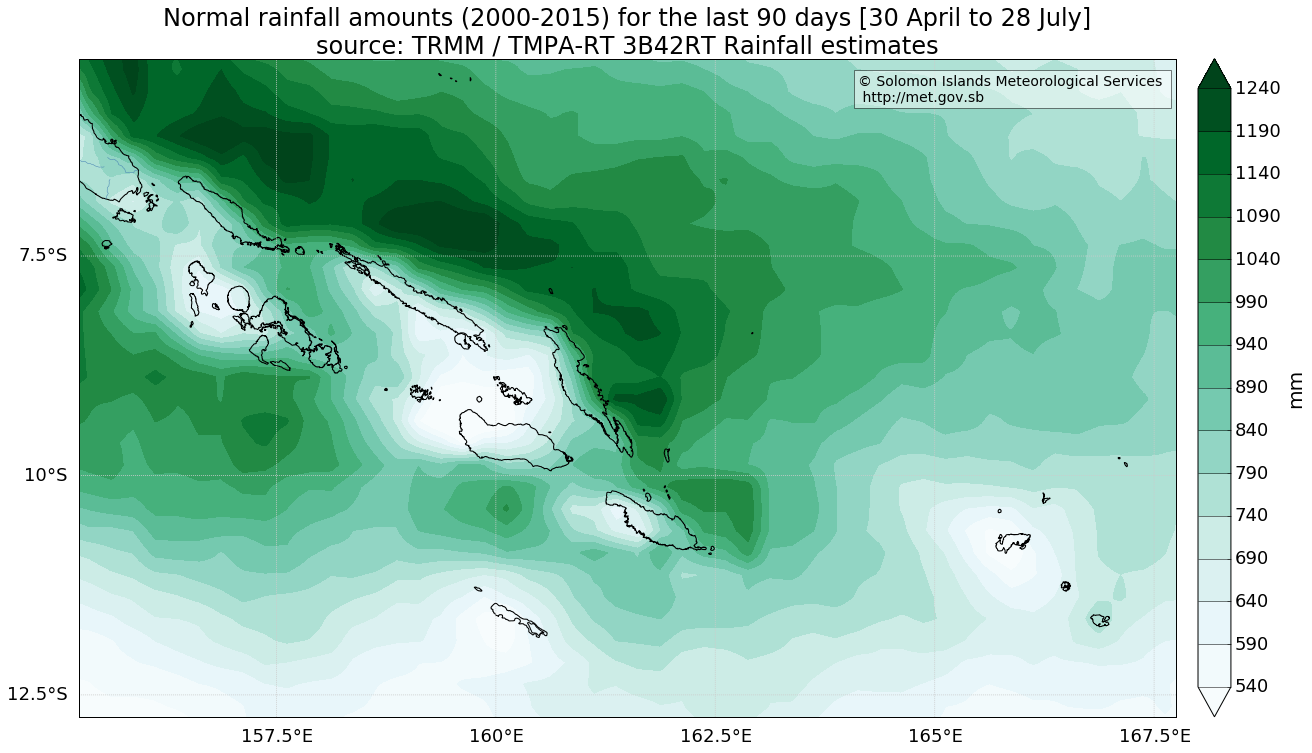

In [42]:
f = plot_map(m, realtime_sum['clim'], title=title, units="mm", draw_cities=True, \
             cmap=plt.get_cmap('BuGn'), extend='both', mask_oceans=False)

In [43]:
f.savefig('../images/realtime_maskocean_CLIM_{}.png'.format(ndays), dpi=200)

In [44]:
!open ../images/realtime_maskocean_CLIM_30.png

### plots the last N days observed rainfall

In [45]:
title = 'Observed rainfall amounts for the last {} days [{:%d %B %Y} to {:%d %B %Y}]\n\
source: TRMM / TMPA-RT 3B42RT Rainfall estimates'\
.format(ndays, realtime[0],realtime[-1])

/Users/nicolasf/anaconda/envs/Root/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


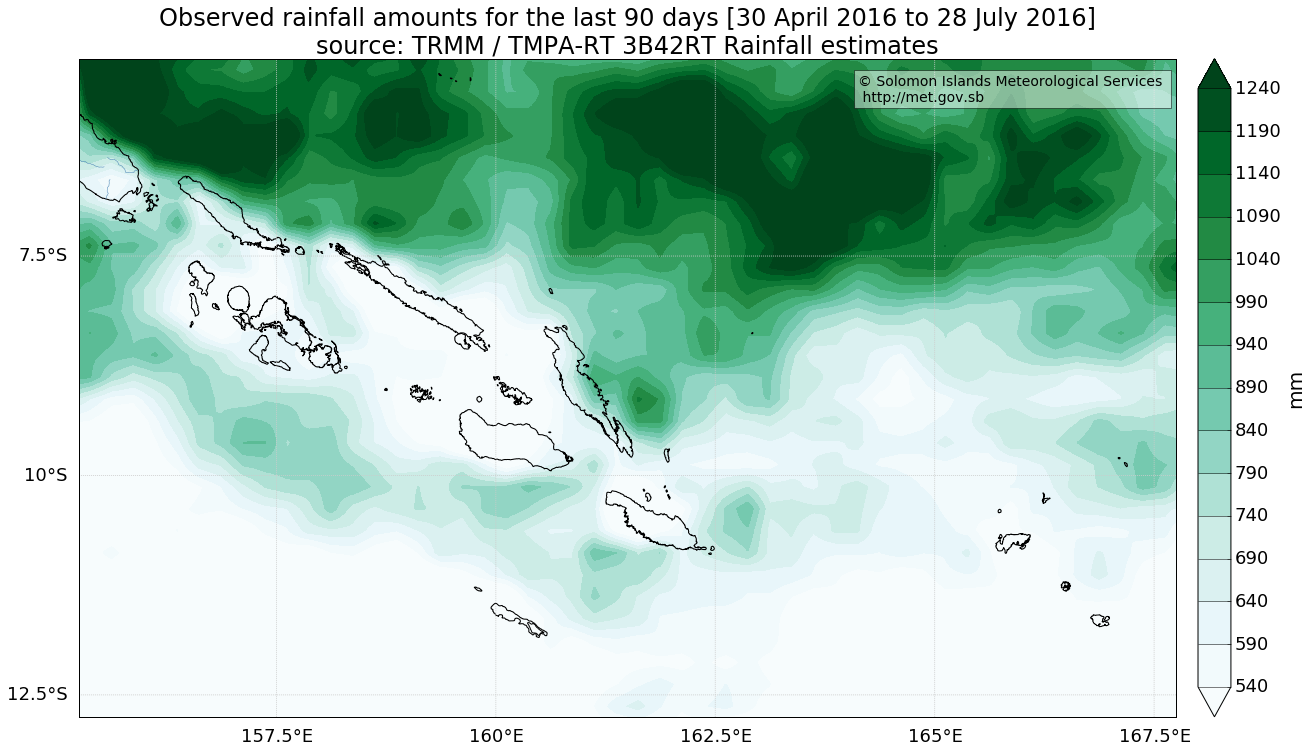

In [46]:
f = plot_map(m, raw, vmin=vmin, vmax=vmax, step=step, title=title, units='mm', draw_cities=True, \
             cmap=plt.get_cmap('BuGn'), extend='both', mask_oceans=False)

In [47]:
f.savefig('../images/realtime_maskocean_OBS_{}.png'.format(ndays), dpi=200)

### plots the anomalies in mm

In [48]:
title = 'Rainfall anomalies amounts for the last {} days [{:%d %B %Y} to {:%d %B %Y}]\n\
source: TRMM / TMPA-RT 3B42RT Rainfall estimates'\
.format(ndays, realtime[0],realtime[-1])

/Users/nicolasf/anaconda/envs/Root/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


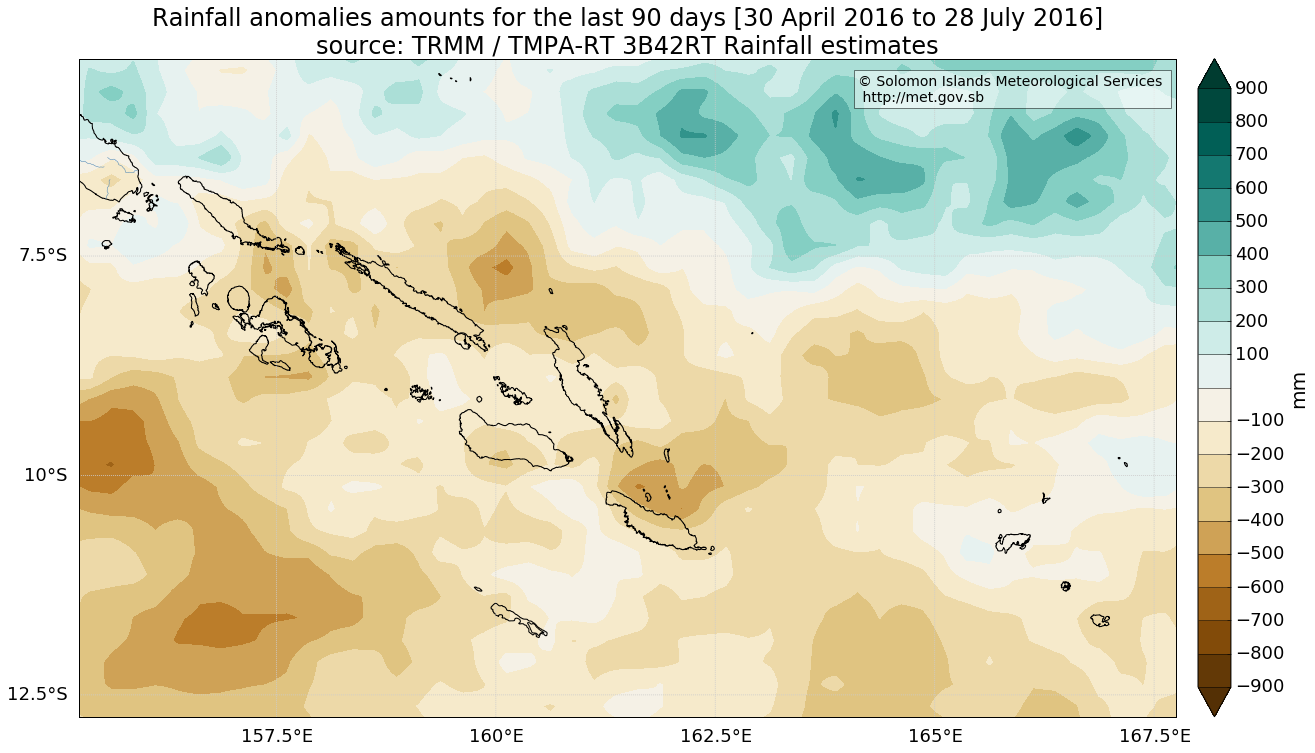

In [49]:
if ndays == 90: 
    f = plot_map(m, anoms, title=title, units='mm', draw_cities=True, cmap=cmap_anoms, \
                 vmin=-900, vmax=900, step=100, extend='both', mask_oceans=False)
if ndays == 60: 
    f = plot_map(m, anoms, title=title, units='mm', draw_cities=True, cmap=cmap_anoms, \
                 vmin=-600, vmax=600, step=60, extend='both', mask_oceans=False)
if ndays == 30: 
    f = plot_map(m, anoms, title=title, units='mm', draw_cities=True, cmap=cmap_anoms, \
             vmin=-400, vmax=400, step=30, extend='both', mask_oceans=False)

In [50]:
f.savefig('../images/last{}days_maskocean_anoms_mm.png'.format(ndays), dpi=200)

In [51]:
title = 'Percentage of normal rainfall for the last {} days [{:%d %B %Y} to {:%d %B %Y}]\n\
source: TRMM / TMPA-RT 3B42RT Rainfall estimates'\
.format(ndays, realtime[0],realtime[-1])

/Users/nicolasf/anaconda/envs/Root/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


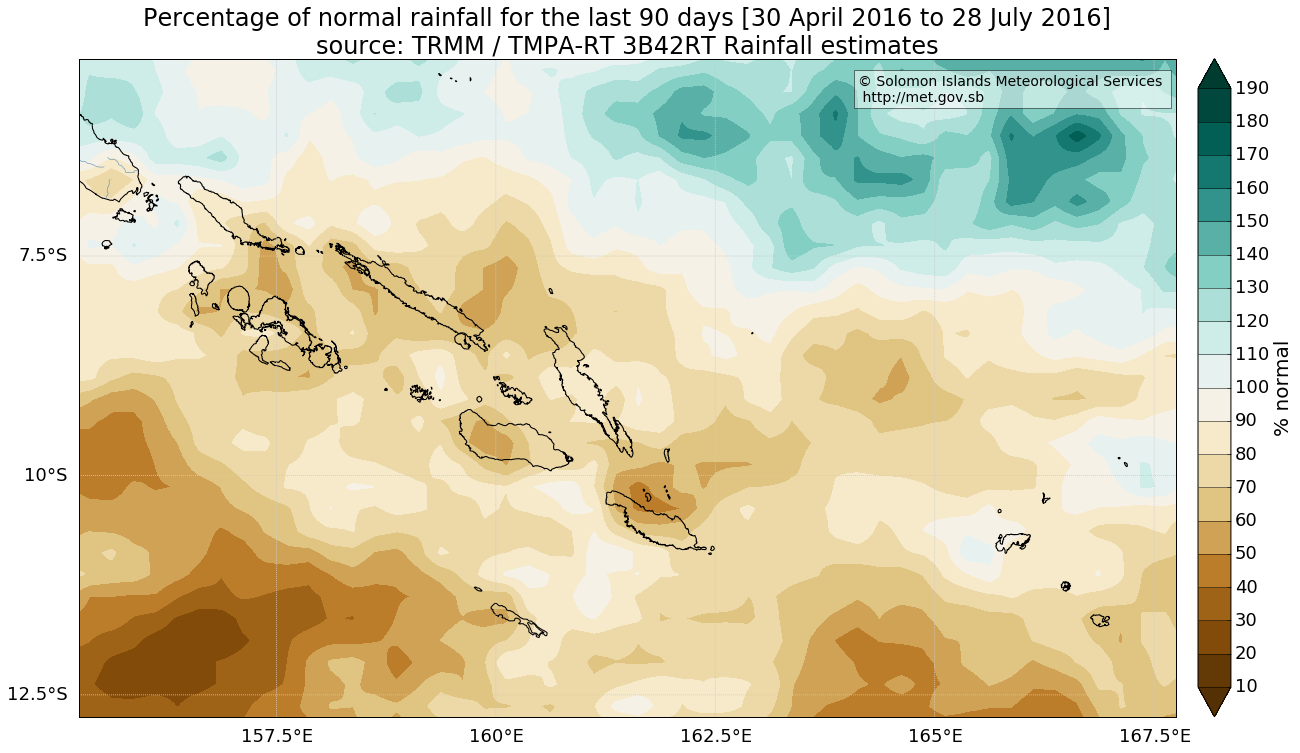

In [52]:
f = plot_map(m, pp, vmin=10, vmax=190, step=10, title=title, units='% normal', \
             draw_cities=True, cmap=cmap_anoms, extend='both', mask_oceans=False)

In [53]:
f.savefig('../images/last{}days_maskocean_anoms_percent_normal.png'.format(ndays), dpi=200)

In [54]:
title = 'Rainfall anomalies (percent. point) for the last {} days [{:%d %B %Y} to {:%d %B %Y}]\n\
source: TRMM / TMPA-RT 3B42RT Rainfall estimates'\
.format(ndays, realtime[0],realtime[-1])

/Users/nicolasf/anaconda/envs/Root/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  xx = x[x.shape[0]/2,:]


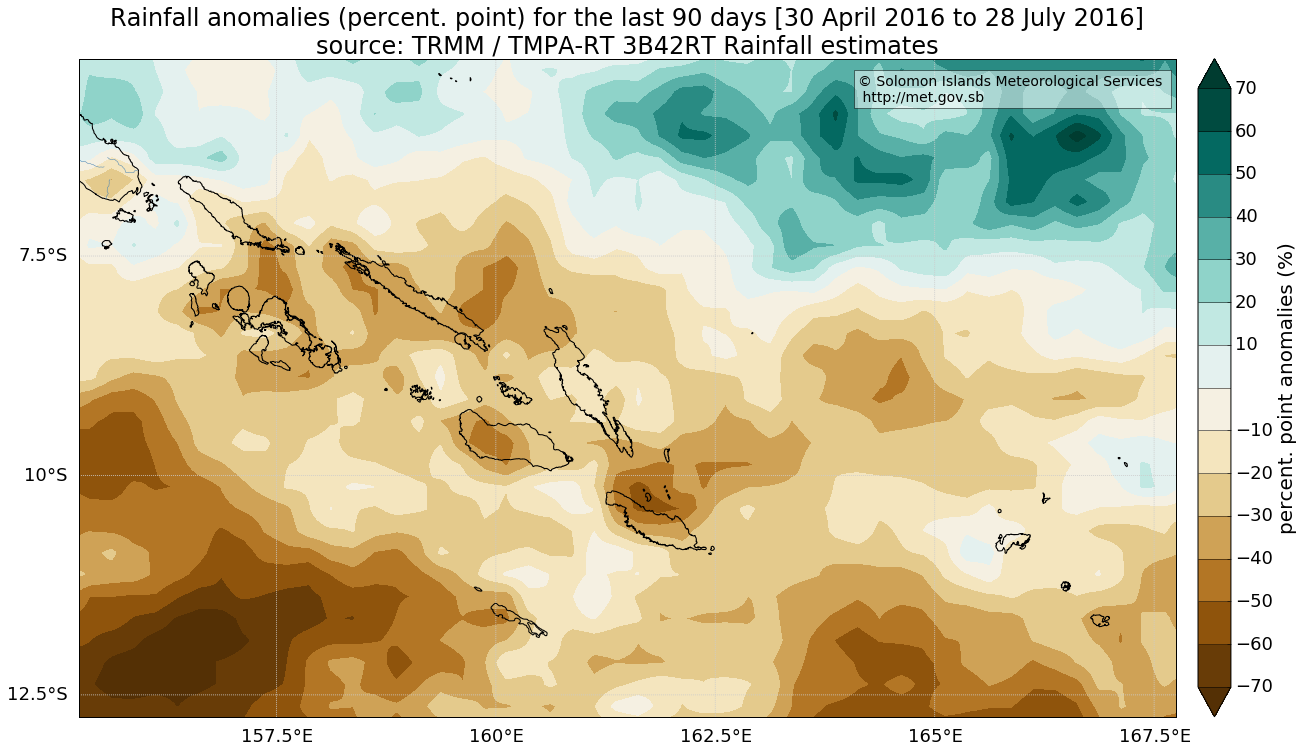

In [55]:
f = plot_map(m, anomsp, title=title, units='percent. point anomalies (%)', draw_cities=True, \
             cmap=cmap_anoms, extend='both', mask_oceans=False)

In [56]:
f.savefig('../images/last{}days_maskocean_anoms_pp.png'.format(ndays), dpi=200)

### plots the virtual stations

In [57]:
Virtual_Stations = pd.read_csv('../data/station_list_Solomon_lat_lon.csv', index_col=0)

In [58]:
Virtual_Stations.tail()

,name_primary,name_secondary,latitude,longitude
33,Gizo,NaN,-8.1000,156.8500
36,Barora,NaN,-8.0333,157.5833
37,Seghe,NaN,-8.5667,157.8833
40,Gibiri,AutoRain,-7.7058,156.7256
41,Mbeulah,AutoRain,-8.2632,157.4279


In [62]:
dsums = {}

for i, row in Virtual_Stations.iterrows(): 
    stn_name = row['name_primary']
    lat_V = row['latitude']
    lon_V = row['longitude']

    
    clim_ts = dset_clim.sel(lat=lat_V, lon=lon_V, method='nearest')['trmm']
    realtime_ts = dset_realtime.sel(lat=lat_V, lon=lon_V, method='nearest')['trmm']
    df_ts = realtime_ts.to_dataframe()[['trmm']]
    df_ts.loc[:,'clim'] = clim_ts.data
    df_ts.columns = ['observed','climatology']


    f = plt.figure(figsize=(12,5))
    ax1 = f.add_axes([0.1,0.25,0.7,0.7])

    ax1.plot(df_ts['climatology'].index, df_ts['climatology'], color='g', label='clim.')
    ax1.plot(df_ts['observed'].index, df_ts['observed'], color='b', label='obs.')

    ax1.fill_between(df_ts['climatology'].index, 0, df_ts['climatology'], color='g', alpha=0.6, label='clim.')
    ax1.fill_between(df_ts['observed'].index, 0, df_ts['observed'], color='b', alpha=0.6, label='obs.')

    [l.set_rotation(90) for l in ax1.xaxis.get_ticklabels()]
    [l.set_fontsize(12) for l in ax1.xaxis.get_ticklabels()]
    [l.set_fontsize(12) for l in ax1.yaxis.get_ticklabels()]

    ax1.legend(fontsize=12)

    ax1.set_xticks(df_ts['climatology'].index[np.arange(1,len(df_ts-5), 5)])

    ax1.set_ylabel("mm", fontsize=12)
    ax1.grid('on')

    ax1.set_title('Last {} days, TRMM / TMPA_RT 3B42RT Virtual Station {}: LAT: {}, LON: {}'\
                 .format(ndays, stn_name, realtime_ts.lat.data, realtime_ts.lon.data), fontsize=12)

    # calculates the sum

    sums = df_ts.sum()

    # plots the cumulative rainfall as barplots

    ax2 = f.add_axes([0.8,0.25,0.14,0.7])
    ax2.bar(np.arange(0.5,2.5), sums.values, width=0.7, color=['b','g'], alpha=0.6, align='center')
    ax2.set_xticks([0.5, 1.5])
    ax2.set_xticklabels(['obs.', 'clim.'], fontsize=12)
    ax2.yaxis.tick_right()
    ax2.set_ylabel("mm", fontsize=12)
    ax2.yaxis.set_label_position("right")
    # ax2.set_yticks(None)
    ax2.set_title("{:4.1f} % of normal".format(np.divide(*sums.values) * 100), fontdict={'weight':'bold'})
    [l.set_fontsize(12) for l in ax2.yaxis.get_ticklabels()]

    stn_name_f = stn_name.replace(" ","_")

    dsums[stn_name] = sums

    f.savefig('../images/Virtual_Station_{}_{}ndays.png'.format(stn_name_f, ndays), dpi=100)
    
    plt.close(f)

In [65]:
df_dsums = pd.DataFrame(dsums)

In [69]:
df_dsums = df_dsums.T

In [72]:
df_dsums = df_dsums.astype(np.int)

In [74]:
df_dsums.head()

,observed,climatology
Afio,585,874
Atoifi,987,1110
Atori,682,938
Avu Avu,558,810
Barora,556,868


In [82]:
cities = {}
for i, row in Virtual_Stations.iterrows():         
    stn_name = row['name_primary']
    lat_V = row['latitude']
    lon_V = row['longitude']
    cities[stn_name] = (lat_V, lon_V)

### plots location map

In [83]:
etopo = xray.open_dataset('/Users/nicolasf/data/etopo/ETOPO1_Ice_g_gmt4.nc')

In [84]:
etopo = etopo.sel(y=slice(domain['latmin'], domain['latmax']), \
                          x=slice(domain['lonmin'], domain['lonmax']))

In [85]:
def plot_cities(ax, cities): 
    for k in cities: 
        ax.plot(cities[k][1],cities[k][0], 'ro', transform=ax.transData)
        ax.text(cities[k][1]+0.05,cities[k][0]+0.01, k, transform=ax.transData, \
                fontdict={'size':10, 'weight':'bold'}, color='#0B0B61', bbox=dict(facecolor='w', edgecolor='w', alpha=0.1))

In [86]:
from mpl_toolkits.basemap import cm

In [87]:
def plot_location_map(m, title="", cities=cities): 
    
    f, ax = plt.subplots(figsize=(30,20))

    m.ax = ax
    m.drawcoastlines(color='k')
    m.drawcountries(linewidth=1)

    meridians = np.arange(140., 160., 5)
    parallels = np.arange(-10., 0., 2.5)

    m.drawparallels(parallels, labels=[1,0,0,0], fontsize=18, linewidth=0.8, color='.8')
    m.drawmeridians(meridians, labels=[0,0,0,1], fontsize=18, linewidth=0.8, color='.8')

    lon = etopo['x'].data.flatten()
    lat = etopo['y'].data.flatten()
    lons, lats = m(*np.meshgrid(lon, lat))
    
    
    etopo_m = maskoceans(lons, lats, etopo['z'], resolution='f', grid=1.25)
    im=m.pcolor(lons, lats, etopo_m,cmap=cm.GMT_haxby,vmin=-2000,vmax=2000, snap=False)
    
    m.drawrivers(color='steelblue')
#     m.drawmapscale(-11.5, 155., -5, 145., 500, barstyle='fancy')
    
#     m.bluemarble()

    m.drawmapboundary(fill_color='steelblue')
    
    # add the copyright blob
    text = u'\N{Copyright Sign}' + ' Solomon Islands Meteorological Services \n http://met.gov.sb'
    ax.text(0.71,0.935, text, transform = ax.transAxes, fontdict={'size':14}, bbox=dict(facecolor='w', alpha=0.9))
        
    ax.set_title(title, fontsize=26)

    plot_cities(ax, cities)
    
    return f

/Users/nicolasf/anaconda/envs/Root/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


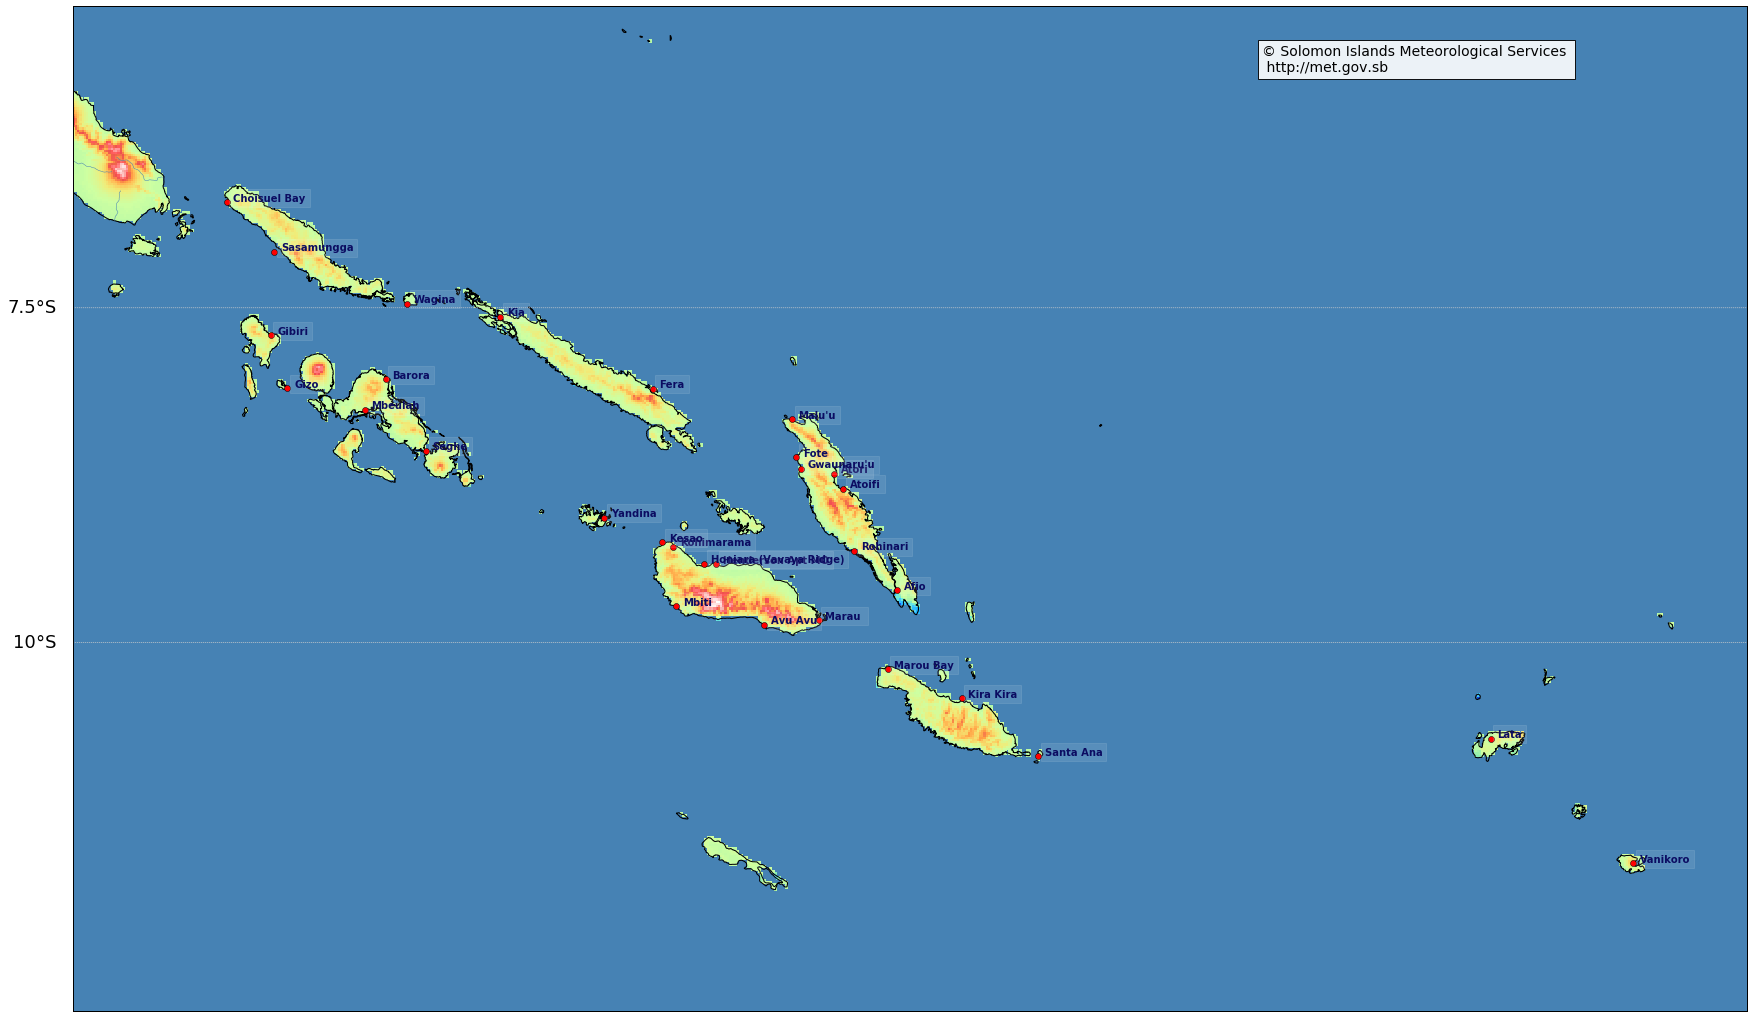

In [88]:
f = plot_location_map(m, title="", cities=cities)

In [92]:
f.savefig('../images/Solomon_Virtual_Stations_location_map.png', dpi=200)

## map with Folium

In [155]:
Virtual_Stations.tail()

,name_primary,name_secondary,latitude,longitude
33,Gizo,NaN,-8.1000,156.8500
36,Barora,NaN,-8.0333,157.5833
37,Seghe,NaN,-8.5667,157.8833
40,Gibiri,AutoRain,-7.7058,156.7256
41,Mbeulah,AutoRain,-8.2632,157.4279


In [314]:
fmap = folium.Map(location=[-9, 163], zoom_start=8, min_lon = 0., max_lon = 360., detect_retina=True)

### add the background layers

In [315]:
add = '/tile/{z}/{y}/{x}'

ESRI = {}
ESRI['World Imagery'] = 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer'
ESRI['World Topography'] = 'http://services.arcgisonline.com/arcgis/rest/services/World_Topo_Map/MapServer'
ESRI['Street Map'] = 'http://services.arcgisonline.com/arcgis/rest/services/World_Street_Map/MapServer'

for tile_name in ['World Imagery','World Topography','Street Map']:
    tile_url = ESRI[tile_name]
    tile_url += add
    fmap.add_tile_layer(name=tile_name,
                     tiles=tile_url, attr='ESRI')

### create a feature group which will include the stations markers 

In [316]:
Solomon_stations = FeatureGroup(name='Show Solomon Islands Stations')

In [317]:
size_icon = (188, 325)

### loops over the stations 

In [318]:
for i in Virtual_Stations.index:
    
    data = Virtual_Stations.ix[i]
    
    name_primary = data.name_primary
    
    obs = df_dsums.ix[name_primary].values[0]
    clim = df_dsums.ix[name_primary].values[1]
    
    anom = (obs / clim) * 100
    
    html = """
    <font face="verdana">
    <div align='center'><h4>
    Last 90 days estimates [TRMM/TMPA] for {}</h4>
    observed = <b>{}</b> mm <br>
    climatology = <b>{}</b> mm <br>
    percent. of normal = <b>{:4.2f}<b> %
    <br><br>
    <a href="http://www.w3schools.com" target="_blank">click here for the time-series</a>
    </font>
    """.format(name_primary, obs, clim, anom)
        
    iframe = folium.element.IFrame(html=html, width=300, height=170)
    
    popup = folium.Popup(iframe, max_width=600)
    
    if anom <= 40: 
        icon = folium.features.CustomIcon('https://raw.githubusercontent.com/nicolasfauchereau/SIMS/master/TRMM/images/icons/orange.png',\
                                         icon_size=(size_icon[0]*0.05, size_icon[1]*0.05))
        marker = folium.map.Marker([data.latitude, data.longitude], icon=icon, popup=popup)   
    elif (anom > 40) & (anom <= 80):
        icon = folium.features.CustomIcon('https://raw.githubusercontent.com/nicolasfauchereau/SIMS/master/TRMM/images/icons/yellow.png',\
                                         icon_size=(size_icon[0]*0.1, size_icon[1]*0.1))
        marker = folium.map.Marker([data.latitude, data.longitude], icon=icon, popup=popup)   
    elif (anom > 80) & (anom < 120):
        icon = folium.features.CustomIcon('https://raw.githubusercontent.com/nicolasfauchereau/SIMS/master/TRMM/images/icons/green.png',\
                                         icon_size=(size_icon[0]*0.15, size_icon[1]*0.15))
        marker = folium.map.Marker([data.latitude, data.longitude], icon=icon, popup=popup)  
    elif (anom >= 120) & (anom < 160):
        icon = folium.features.CustomIcon('https://raw.githubusercontent.com/nicolasfauchereau/SIMS/master/TRMM/images/icons/blue.png',\
                                         icon_size=(size_icon[0]*0.2, size_icon[1]*0.2))
        marker = folium.map.Marker([data.latitude, data.longitude], icon=icon, popup=popup)  
    elif anom > 160:
        icon = folium.features.CustomIcon('https://raw.githubusercontent.com/nicolasfauchereau/SIMS/master/TRMM/images/icons/deepblue.png',\
                                         icon_size=(size_icon[0]*0.25, size_icon[1]*0.25))
        marker = folium.map.Marker([data.latitude, data.longitude], icon=icon, popup=popup)  
    
#     c = folium.CircleMarker(location=[data.latitude, data.longitude], popup=popup, color='red', fill_color='red', \
#                         fill_opacity=0.4, radius=5000)
    
#     c  = folium.Marker(location=[data.latitude, data.longitude], popup=popup)
    
    # add to fature group
    Solomon_stations.add_children(marker)

In [319]:
fmap.add_children(Solomon_stations)
fmap.add_children(folium.map.LayerControl())

In [320]:
fmap.save('./interactive_map_Solomon.html')

In [313]:
!open ./interactive_map_Solomon.html

In [129]:
folium.CustomIcon?

In [224]:
325 / 188

1.7287234042553192

In [231]:
0.5 * np.array([188, 325])

array([  94. ,  162.5])